In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.image import imread
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#### X Train
X_train_original = pd.read_csv("./DATA/X_train_update.csv" , sep = ',', header = 0, index_col = 0 )
# 84916 entries
print("X_train_original.info: ", X_train_original.info())
print("X_train_original.shape: ", X_train_original.shape)

# Y Train
y_train = pd.read_csv("./DATA/Y_train_CVw08PX.csv" , sep = ',', header = 0, index_col = 0 )
# 84916 entries
print("y_train.info: ", y_train.info())
print("y_train.shape: ", y_train.shape)

Product_catalog = pd.read_csv("./DATA/product_catalog.csv", sep = ';', header = 0)
# 27 entries
print("Product_catalog.info: ", Product_catalog.info())

###
dict_code_to_id={}
dict_id_to_code={}

list_tags = list(y_train['prdtypecode'].unique())

for i,tag in enumerate(list_tags):
    dict_code_to_id[tag] = i 
    dict_id_to_code[i]=tag
    
y_train['label'] = y_train['prdtypecode'].map(dict_code_to_id)

X_train_original['description_ok'] = X_train_original['description'].fillna('')
X_train_original['text_tag'] = X_train_original.apply(lambda row: row['designation'] + row['description_ok'], axis=1)

#compilation
r_tag = re.compile(r"<.*?>")

def text_tag_fn(text):
    text_ = ""
    for txt in text :
        text_ += txt
    return r_tag.sub(' ', text_)

#X_train_original['text']
X_train_original['text'] = X_train_original['text_tag'].apply(text_tag_fn)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB
X_train_original.info:  None
X_train_original.shape:  (84916, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB
y_train.info:  None
y_train.shape:  (84916, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  27 non-null     

In [4]:
X_train_original['label'] = y_train['label']
X_train_original['label'] = X_train_original['label'].astype('string')

In [343]:
#######################################################################################################################################################
# (128,128), (256,256)
TARGET_SIZE = (256,256)
# 32, 64
BATCH_SIZE = 64
# 0.01, 0.001
LEARNING_RATE = 0.01

In [7]:

# ./DATA/images/image_train/image_1172460449_product_185143847.jpg
X_train_original['path'] = X_train_original.apply(lambda row: "./DATA/images/image_train/image_"+str(row['imageid'])+"_product_"+str(row['productid'])+".jpg", axis = 1)

#X_feats_path, X_test_path, y_feats, y_test = train_test_split(X_train['path'], y_train['label'], test_size = 0.1, random_state=1234, stratify=y_train['label'])
X_feats, X_test, y_feats, y_test = train_test_split(X_train_original, y_train['label'], test_size = 0.1, random_state=1234) # , stratify=y_train['label']

X_train, X_val, y_train, y_val = train_test_split(X_feats, y_feats, test_size = 0.2, random_state=1235)  # , stratify=y_feats

X_train_path, X_val_path, X_test_path = X_train['path'], X_val['path'], X_test['path']

X_train_dataFrame = pd.DataFrame(X_train_path, columns=['path'])
X_train_dataFrame['label'] = y_train
X_train_dataFrame['label'] = X_train_dataFrame['label'].astype('string')

X_val_dataFrame = pd.DataFrame(X_val_path, columns=['path'])
X_val_dataFrame['label'] = y_val
X_val_dataFrame['label'] = X_val_dataFrame['label'].astype('string')

In [8]:
# SPLIT TRAIN & TEST SETS
data_train_feats, data_test = train_test_split(
    X_train_original,                       # cleaned Pandas DataFrame
    test_size = 0.1,      # size of validation observations
    shuffle = True,             # shuffle observations (explicitly)
    stratify = X_train_original['label'],# preserve distribution of labels
    random_state = 123   # seed for shuffling observations
)

In [9]:
# SPLIT TRAIN & TEST SETS
data_train, data_val = train_test_split(
    data_train_feats,                       # cleaned Pandas DataFrame
    test_size = 0.2,      # size of validation observations
    shuffle = True,             # shuffle observations (explicitly)
    stratify = data_train_feats['label'],# preserve distribution of labels
    random_state = 1235   # seed for shuffling observations
)

In [10]:
# TRAINING GENERATOR
# Configure ImageDataGenerator
img_gen_train = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    # data augmentation
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 1.1,
    horizontal_flip = True
)
# Generate DataFrameIterator
data_flow_train = img_gen_train.flow_from_dataframe(
    dataframe = data_train,	  # use training observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = True,           # shuffle observations (explicitly)
    seed = 1222,          # /!\ for reproductibility /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded => sparse
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)

# VALIDATION GENERATOR
# Configure ImageDataGenerator
img_gen_val = ImageDataGenerator(
    preprocessing_function = preprocess_input	# /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_val = img_gen_val.flow_from_dataframe(
    dataframe = data_val,     # use validation observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = False,		  # /!\ shuffling this changes labels encoding /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded sparse
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)


Found 61139 validated image filenames belonging to 27 classes.
Found 15285 validated image filenames belonging to 27 classes.


In [11]:
# TEST GENERATOR
# Configure ImageDataGenerator
img_gen_test = ImageDataGenerator(
    preprocessing_function = preprocess_input	# /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_test = img_gen_test.flow_from_dataframe(
    dataframe = data_test,     # use validation observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = False,		  # /!\ shuffling this changes labels encoding /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)

Found 8492 validated image filenames belonging to 27 classes.


In [12]:
#data_test.to_csv("./data_test_csv.csv")

In [30]:
#####

In [344]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

MODEL_BASE = './' + str(BATCH_SIZE) + '_' + str(LEARNING_RATE) + '_'
MODEL_JSON = ''
MODEL_H5 = ''

#################################################################################################
# ResNet50, VGG16, MobileNetV2

#IMAGE_ALGO = 'MobileNetV2'
#IMAGE_ALGO = 'ResNet50'
IMAGE_ALGO = 'VGG16'

# 1
if IMAGE_ALGO == 'ResNet50':
    # Chargement du modèle efficientNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningResNet50.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningResNet50.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        #print("layer.name: ", layer.name)
        layer.trainable = False

    base_model.summary()

# 2
if IMAGE_ALGO == 'VGG16':
    # Modèle VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningVGG16.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningVGG16.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

# 3
if IMAGE_ALGO == 'MobileNetV2':
    # Modèle MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningMobileNet_V2.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningMobileNet_V2.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [345]:
#######################################################################################################################################
# Load model
from tensorflow import keras
from keras.models import model_from_json

with open(MODEL_JSON, 'r') as fx:
    model_json_string = fx.read()

reconstructed_model_image = model_from_json(model_json_string)
reconstructed_model_image.load_weights(MODEL_H5)

In [346]:
MODEL_H5

'./64_0.01_classifierTranferLearningVGG16.h5'

In [347]:
######################################################################################################################################
######################################################################################################################################

In [348]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

reconstructed_y_prob = reconstructed_model_image.predict(
    x = data_flow_test,    # use validation generator
    batch_size = None,    # specified by generator
    steps = None,         # specified by generator
    verbose = 1
)

133/133 [==============================] - 937s 7s/step


In [349]:
y_prob_image = reconstructed_y_prob

In [350]:
dict_img_classes={'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26}

def get_class_num_from_img_idx(int_index):
    for str_key, int_val in dict_img_classes.items():
        if int_index == int_val:
            real_class = str_key
    return int(real_class)

In [351]:
tmp_matrix=np.zeros(y_prob_image.shape)
for ligne in range(y_prob_image.shape[0]):
    for colonne in range(y_prob_image.shape[1]):
        true_ind=get_class_num_from_img_idx(colonne)
        tmp_matrix[ligne][true_ind]=y_prob_image[ligne][colonne]

In [352]:
y_prob_image = tmp_matrix

In [196]:
####################################################################################################################################

In [23]:
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################

In [24]:
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olivierdouangvichith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olivierdouangvichith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
stop_words = stopwords.words(['french', 'english'])
#stop_words2 = stopwords.words('english')

In [26]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]

    return ' '.join(mots).strip()

In [27]:
X_train.text = X_train.text.swifter.apply(lambda x :preprocess_sentence(x))
X_train.text.head(10)

Pandas Apply:   0%|          | 0/61139 [00:00<?, ?it/s]

/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


3436     chefs oeuvre art grands peintres hachette edit...
34252                   couronne tuyau cristal tresse arme
14469    figurine pop moche mechant gru spy funko pop f...
40003    kaleidoscope short stories ray bradbury lire a...
9185     thermometre piscine baignoire bassin flottant ...
362      doctor mug cosmosmug grande tasse ceramique de...
71491    carnet notes bloc notes cahierl australie save...
81758    aeternitas nasci vivere mori aeternitas histoi...
28021    ! lval destructeur dododo communesi adversaire...
19586    taie oreiller animal mignon coussin sofa case ...
Name: text, dtype: object

In [28]:
import tensorflow as tf

# Définition du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)

# Mettre à jour le dictionnaire du tokenizer
tokenizer.fit_on_texts(X_train.text)

In [29]:
# Définition des dictionnaires
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = tokenizer.num_words

In [30]:
vocab_size

10000

In [164]:
#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################

In [398]:
# Load model
from tensorflow import keras

reconstructed_model = keras.models.load_model("64_0.001_textClassifierRNNBow.h5")

In [399]:
maxlen = 48
X_test.sequences = tokenizer.texts_to_sequences(X_test.text)
X_test.sequences = tf.keras.preprocessing.sequence.pad_sequences(X_test.sequences, maxlen=maxlen, padding='post')

In [400]:
reconstructed_model.evaluate(X_test.sequences, y_test.values, batch_size=64, return_dict=True)

133/133 [==============================] - 8s 55ms/step - loss: 2.0733 - accuracy: 0.3952


{'loss': 2.0732996463775635, 'accuracy': 0.39519548416137695}

In [401]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

X_test.sequences = tokenizer.texts_to_sequences(X_test.text)
X_test.sequences = tf.keras.preprocessing.sequence.pad_sequences(X_test.sequences, maxlen=maxlen, padding='post')

In [402]:
# Test All

In [403]:
y_predd = reconstructed_model.predict(X_test.sequences)

In [404]:
y_prob_text = y_predd

In [405]:
##########################################################################################################

In [406]:
#### Model final

In [407]:
y_prob_final = (y_prob_text+y_prob_image) / 2

In [408]:
final_class_indices = np.argmax(y_prob_final, axis=-1)

In [409]:
mat_confus_final = confusion_matrix(y_test.values, final_class_indices)

In [410]:
accuracy_final = accuracy_score(y_test.values, final_class_indices)
print('Accuracy :', accuracy_final)

Accuracy : 0.21855864342910974


In [411]:
#for i in range(27):
#    print("Classe réelle: ", str(Product_catalog[Product_catalog.prdtypecode==dict_id_to_code[i]]['description'].values[0]))

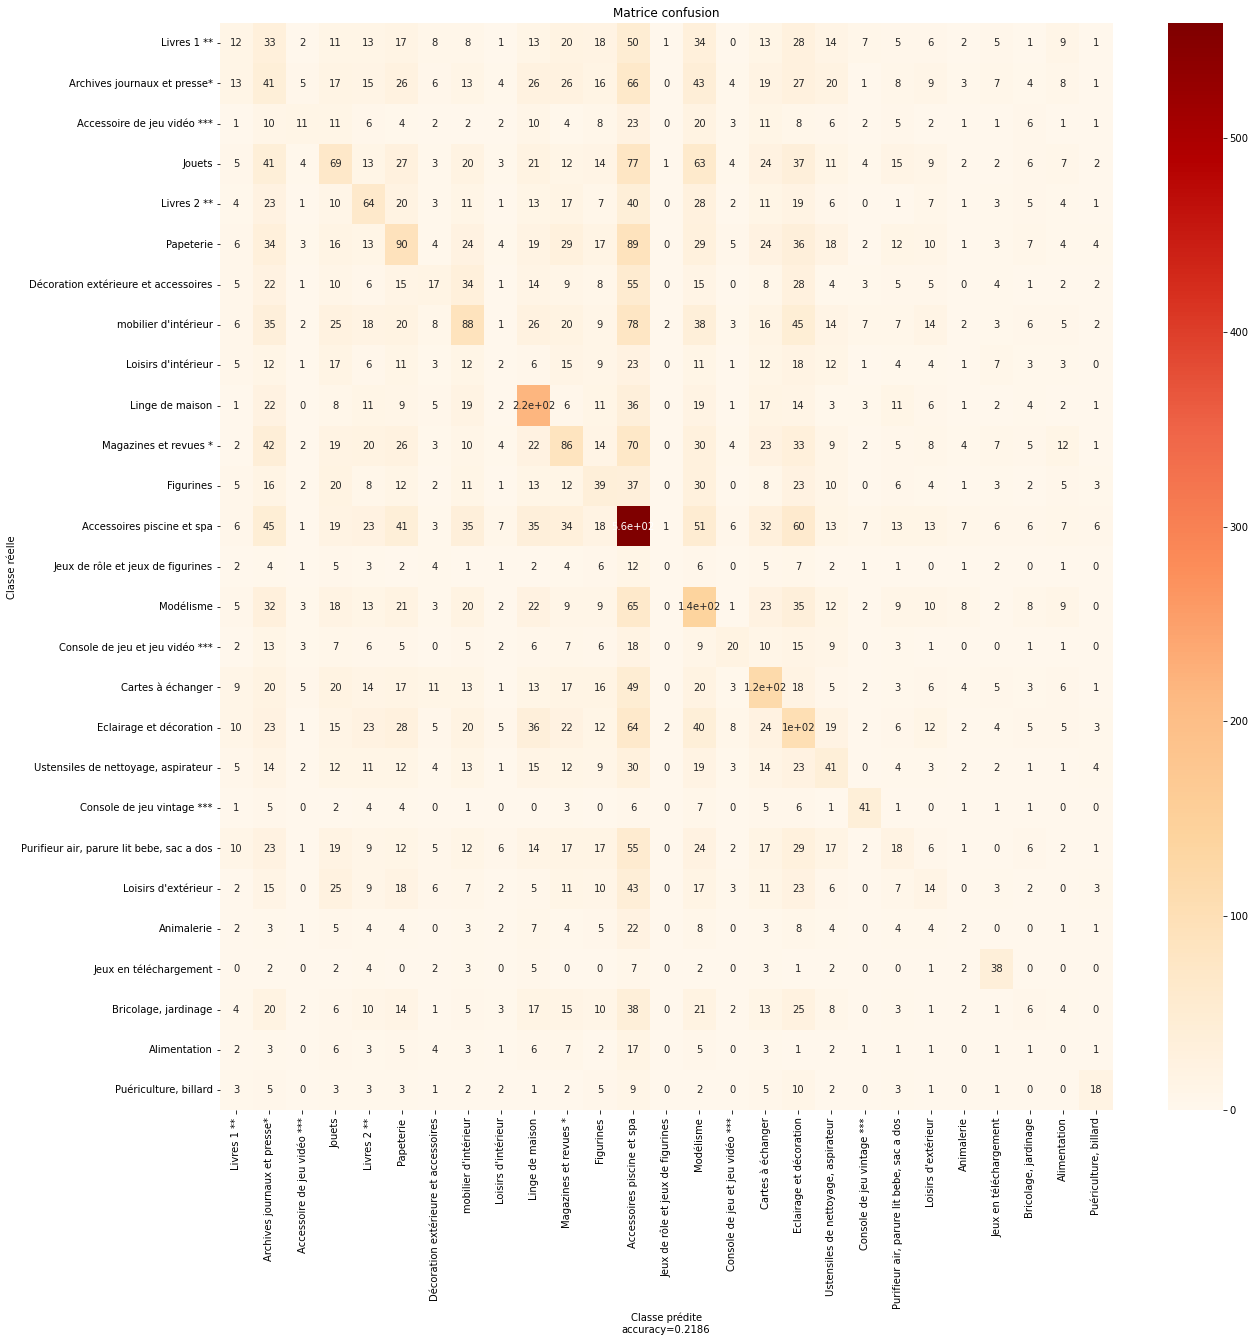

In [412]:
import seaborn as sns
from sklearn.metrics import accuracy_score

plt.figure(figsize=(20, 20))

ax = plt.subplot()
sns.heatmap(mat_confus_final, annot=True, cmap="OrRd", ax=ax)

plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite\naccuracy={:0.4f}'.format(accuracy_final))

ax.set_title('Matrice confusion');

ax.xaxis.set_ticklabels([Product_catalog[Product_catalog.prdtypecode==dict_id_to_code[i]]['description'].values[0] for i in range(27)], rotation = 90);
ax.yaxis.set_ticklabels([Product_catalog[Product_catalog.prdtypecode==dict_id_to_code[i]]['description'].values[0] for i in range(27)], rotation = 0);

plt.savefig('./64_0.01_mcVGG16_RNNGRU_0.001.png')
#plt.savefig('./MC_TEST.png')

In [297]:
from sklearn import metrics
f1_score = metrics.f1_score(y_test.values, final_class_indices, average='weighted')
print('Reconstructed f1_score :', f1_score)

Reconstructed f1_score : 0.6031521068370698


In [298]:
print(metrics.classification_report(y_test.values, final_class_indices))

              precision    recall  f1-score   support

           0       0.31      0.27      0.29       332
           1       0.38      0.53      0.44       428
           2       0.63      0.50      0.56       161
           3       0.50      0.35      0.41       496
           4       0.61      0.54      0.57       302
           5       0.74      0.78      0.76       503
           6       0.71      0.55      0.62       274
           7       0.65      0.52      0.58       500
           8       0.52      0.28      0.37       199
           9       0.65      0.76      0.70       431
          10       0.64      0.56      0.60       463
          11       0.65      0.67      0.66       273
          12       0.71      0.92      0.80      1054
          13       0.55      0.37      0.44        73
          14       0.59      0.69      0.64       482
          15       0.71      0.58      0.64       149
          16       0.54      0.73      0.62       399
          17       0.61    